In [ ]:
# Importing working libraries
import os
import cv2
import json
import copy
import openpyxl
import math as m
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from datetime import datetime
from matplotlib import pyplot as plt
from openpyxl.styles import Alignment
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

# Select your development environment
environment = "Google Colab" # "Google Colab", "Local"

# Loading depending on environment
project_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  project_path = "/content/drive/MyDrive/Colab Notebooks/UAB Project/Machine Learning/Project/UAB23-Machine-Learning-Project"
else:
  project_path = "../"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Useful functions for the future

def normalization(x,mu,sigma):
    return((x - mu) / sigma)

def polynomial_transformation(features,deg):
  # Creation of polynomial features
  poly = PolynomialFeatures(deg)
  features_p_deg = poly.fit_transform(features) # Add column 1 in all cases
  # Number of exit features = Combinations of (degree_of_polynomial) among (degree_of_polynomial + number_of_input_features)
  # For 11 features and deg = 3 -> 3 among 11+3 = 364 exit features
  # For 5 features and deg = 3 -> 3 among 5+3 = 56 exit features
  return(features_p_deg)

def normalization_training_dataset(features_p_deg):
  # Normalisation of all columns except X0
  mu_p_deg = features_p_deg.mean(axis=0)
  sigma_p_deg = features_p_deg.std(axis=0, ddof=1)
  for i in range(1, features_p_deg.shape[1]):
    features_p_deg[:, i] = normalization(features_p_deg[:, i], mu_p_deg[i], sigma_p_deg[i])
  return(features_p_deg,mu_p_deg,sigma_p_deg)

def normalization_test_dataset(features_p_deg,mu_p_deg,sigma_p_deg):
  # Normalisation of all columns except X0
  for i in range(1, features_p_deg.shape[1]):
    features_p_deg[:, i] = normalization(features_p_deg[:, i], mu_p_deg[i], sigma_p_deg[i])
  return(features_p_deg)

def transform_categorical_to_binary(df):
  for feature in categorical_features:
    df = pd.get_dummies(df, columns=[feature])
  return(df.to_numpy())

def metrics(prediction, target):
    # Calculation of TP, TN, FP, and FN
    tp = np.sum((prediction == 1) & (target == 1))
    tn = np.sum((prediction == 0) & (target == 0))
    fp = np.sum((prediction == 1) & (target == 0))
    fn = np.sum((prediction == 0) & (target == 1))
    # Calculation of metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    f_score = (2 * precision * recall) / (precision + recall)
    # Creating a dictionary to return the metrics
    metrics_dict = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "Specificity": specificity,
        "F-Score": f_score
    }
    return(metrics_dict)

In [ ]:
# Load paths
path_excel = os.path.join(project_path, "results/results.xlsx")
path_excel_ensemble_learning = os.path.join(project_path, "results/results_ensemble_learning.xlsx")
path_csv_train_original = os.path.join(project_path, "dataset/train/train_original.csv")
path_csv_train_without_impossible = os.path.join(project_path, "dataset/train/train_without_impossible_values.csv")
path_csv_train_without_extreme = os.path.join(project_path, "dataset/train/train_without_extreme_values.csv")
path_csv_test = os.path.join(project_path, "dataset/test/test_original.csv")

# Loading datasets using pandas
train_original = pd.read_csv(path_csv_train_original, delimiter=';')
train_without_impossible_dataset = pd.read_csv(path_csv_train_without_impossible, delimiter=',')
train_without_extreme_dataset = pd.read_csv(path_csv_train_without_extreme, delimiter=',')
test_dataset = pd.read_csv(path_csv_test, delimiter=';')

# Creating lists of features
names_features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [ ]:
def prepare_training_data(data_pandas, deg):
    # Separation of numerical, categorical, and target data
    numerical_training_dataset = data_pandas[numerical_features]
    categorical_training_dataset = data_pandas[categorical_features]
    y = data_pandas['cardio']
    # For each categorical data, make the column binary
    categorical_training_dataset = transform_categorical_to_binary(categorical_training_dataset)
    # Polynomial transformation of numerical data
    numerical_training_dataset = polynomial_transformation(numerical_training_dataset, deg)
    # Normalize numerical data
    numerical_training_dataset, mu_deg, sigma_deg = normalization_training_dataset(numerical_training_dataset)
    # Merge the new numerical and categorical data
    X = np.hstack((numerical_training_dataset, categorical_training_dataset))
    return X, y, mu_deg, sigma_deg

def prepare_test_data(data_pandas, deg, mu_deg, sigma_deg):
    # Separation of numerical, categorical, and target data
    numerical_test_dataset = data_pandas[numerical_features]
    categorical_test_dataset = data_pandas[categorical_features]
    y = data_pandas['cardio']
    # For each categorical data, make the column binary
    categorical_test_dataset = transform_categorical_to_binary(categorical_test_dataset)
    # Polynomial transformation of numerical data
    numerical_test_dataset = polynomial_transformation(numerical_test_dataset, deg)
    # Normalize numerical data using mu_deg and sigma_deg as parameters
    numerical_test_dataset = normalization_test_dataset(numerical_test_dataset, mu_deg, sigma_deg)
    # Merge the new numerical and categorical data
    X = np.hstack((numerical_test_dataset, categorical_test_dataset))
    return X, y

def complete_preparation(data_pandas_train, data_pandas_test, deg):
    X_train, y_train, mu_deg, sigma_deg = prepare_training_data(data_pandas_train, deg)
    X_test, y_test = prepare_test_data(data_pandas_test, deg, mu_deg, sigma_deg)
    return X_train, y_train, X_test, y_test, mu_deg, sigma_deg

def training_and_performance_assessment(parameterized_model, X_train, y_train, X_test, y_test):
    # Model training
    model = parameterized_model
    model.fit(X_train, y_train)
    # Evaluation of the model on training data
    prediction = model.predict(X_test)
    metrics_dict = metrics(prediction, y_test)
    for metric_name, metric_value in metrics_dict.items():
        print(metric_name, " : ", metric_value)
    return metrics_dict

def performance_assessment(model, X_test, y_test):
    # Evaluation of the model on training data
    prediction = model.predict(X_test)
    metrics_dict = metrics(prediction, y_test)
    for metric_name, metric_value in metrics_dict.items():
        print(metric_name, " : ", metric_value)
    return metrics_dict

def write_to_excel(file_name, text):
    try:
        wb = openpyxl.load_workbook(file_name)
        sheet = wb.active  # Select the first sheet
        # Find the first empty row
        row = 6
        while sheet.cell(row=row, column=2).value is not None:
            row += 1
        # Write the text into column B at the found row
        for i in range(len(text)):
            cell = sheet.cell(row=row, column=2 + i)
            cell.value = text[i]
        # Save the modifications to the Excel file
        wb.save(file_name)
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "SVM": SVC()
}
classifier_parameters = {
    "LogisticRegression": {
        "penalty": [None,'l1', 'l2','elasticnet'],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "max_iter": [20000],
        "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        "random_state": [42]
    },
    "RandomForestClassifier": {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "random_state": [42]
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 10, 20, 50, 100],
        "weights": ['uniform', 'distance'],
        "p": [1, 2]
    },
    "GaussianNB": {},
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf', 'poly'],
        "gamma": ['scale', 'auto'],
        "random_state": [42]
    }
}
train_datasets = {
    "train_original_dataset": train_original,
    "train_without_impossible_dataset": train_without_impossible_dataset,
    "train_without_extreme_dataset": train_without_extreme_dataset
}
range_of_degrees = range(1, 3)

---

Training and testing of all classifiers can now begin

---

In [ ]:
# # Test all classifiers with all possible parameters, degrees, and both datasets cleaned differently
# for deg in range_of_degrees:
#   for classifier_name, classifier in classifiers.items():
#         for train_dataset_name, train_dataset in train_datasets.items():
#             if classifier_name == "SVM" and deg > 1:
#                 break
#             print(f"---> Classifier name: {classifier_name} - Degree: {deg} - Training data: {train_dataset_name}")
#             # Load the data
#             X_train, y_train, X_test, y_test, _, _ = complete_preparation(train_dataset, test_dataset, deg)
#             # Load the model
#             model = copy.deepcopy(classifier)
#             # Check if parameters are specified for the classifier
#             if classifier_name in classifier_parameters:
#                 # Select the parameters to test
#                 params = classifier_parameters[classifier_name]
#                 # Search for the best parameters through cross-validation
#                 grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
#                 grid_search.fit(X_train, y_train)
#                 # Display of the best parameters and the best accuracy
#                 print(f"Best Parameters: {grid_search.best_params_}")
#                 print(f"Best Accuracy: {grid_search.best_score_}\n")
#                 # Dynamically add attributes to the model
#                 for param, value in grid_search.best_params_.items():
#                     setattr(model, param, value)
#             # Now let's train on the entire training data with the best parameters
#             metrics_dict = training_and_performance_assessment(model, X_train, y_train, X_test, y_test)
#             # Now let's save the metrics in the results excel file
#             content_for_excel = [classifier_name, str(grid_search.best_params_), deg, train_dataset_name.split("_")[2]]
#             for _, metric_value in metrics_dict.items():
#                 content_for_excel.append(round(metric_value, 3))
#             # Write the results in excel
#             write_to_excel(path_excel, content_for_excel)

---

All the results of this execution are in the results.xlsx file

---

Let's observe the ROC curve of the classifiers with their default parameters

---

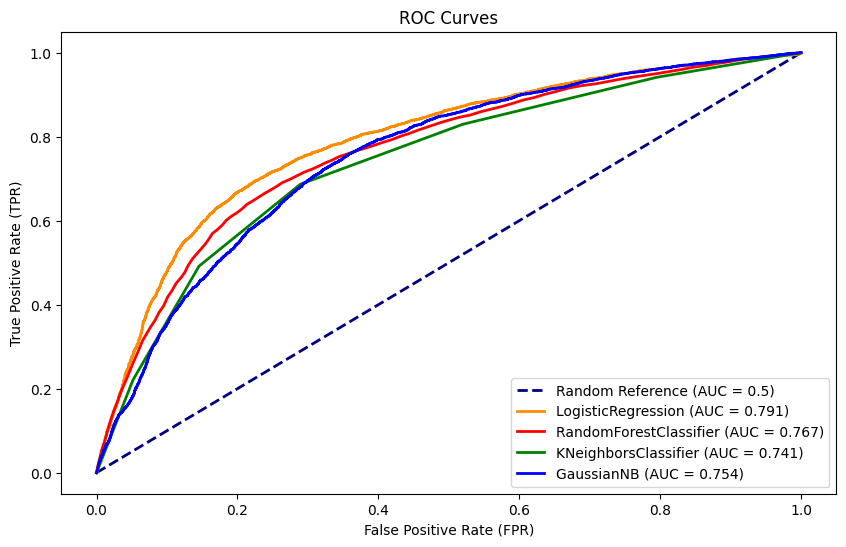

In [ ]:
# Set parameters
deg = 1
train_dataset = train_without_extreme_dataset
models = {
    "LogisticRegression" : {
        "model" : LogisticRegression(),
        "color" : "darkorange"
        },
    "RandomForestClassifier" : {
        "model" : RandomForestClassifier(),
        "color" : "red"
        },
    "KNeighborsClassifier" : {
        "model" : KNeighborsClassifier(),
        "color" : "green"
        },
    "GaussianNB" : {
        "model" : GaussianNB(),
        "color" : "blue"
        },
    "SVM" : {
        "model" : SVC(probability=True),
        "color" : "yellow"
        }
    }

def display_ROC_curve(deg,model,train_dataset,model_name,color):
  # Data preparation
  X_train, y_train, X_test, y_test, _, _ = complete_preparation(train_dataset, test_dataset, deg)
  # Train the chosen model
  model.fit(X_train, y_train)
  # Get predicted scores on the test set
  y_scores = model.predict_proba(X_test)[:, 1]
  # Calculate the ROC curve
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  # Calculate the area under the ROC curve (AUC)
  roc_auc = auc(fpr, tpr)
  # Plot the ROC curve
  plt.plot(fpr, tpr, color=color, lw=2, label=f"{model_name} (AUC = {round(roc_auc,3)})")

# Display setup
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Reference (AUC = 0.5)')
# Display all curves for each classifier
for key, value in models.items():
  display_ROC_curve(deg, value["model"], train_dataset, key, value["color"])
# Finish setup and display
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves of classifiers with their default parameters')
plt.legend(loc='lower right')
plt.show()

---

Now let's observe the ROC curve of the best and worst classifier.

---

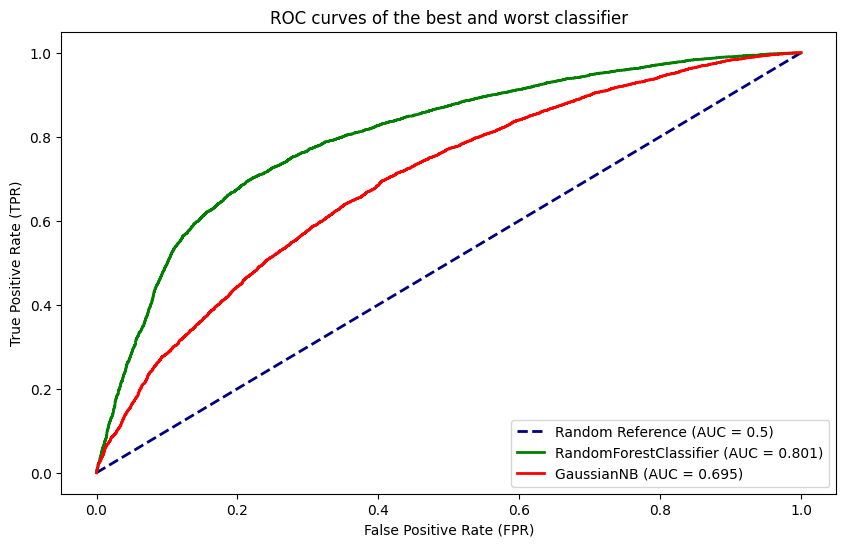

In [ ]:
# Set parameters
models = {
    "RandomForestClassifier" : {
        "model" : RandomForestClassifier(),
        "params" : {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42},
        "deg" : 2,
        "dataset" : train_without_impossible_dataset,
        "color" : "green"
        },
    "GaussianNB" : {
        "model" : GaussianNB(),
        "params" : {},
        "deg" : 2,
        "dataset" : train_original,
        "color" : "red"
        }
}

def display_ROC_curve(deg,model,params,train_dataset,model_name,color):
  # Data preparation
  X_train, y_train, X_test, y_test, _, _ = complete_preparation(train_dataset, test_dataset, deg)
  # Train the chosen model
  model.set_params(**params)
  model.fit(X_train, y_train)
  # Get predicted scores on the test set
  y_scores = model.predict_proba(X_test)[:, 1]
  # Calculate the ROC curve
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  # Calculate the area under the ROC curve (AUC)
  roc_auc = auc(fpr, tpr)
  # Plot the ROC curve
  plt.plot(fpr, tpr, color=color, lw=2, label=f"{model_name} (AUC = {round(roc_auc,3)})")

# Display setup
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Reference (AUC = 0.5)')
# Display all curves for each classifier
for key, value in models.items():
  display_ROC_curve(value["deg"], value["model"], value["params"], value["dataset"], key, value["color"])
# Finish setup and display
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves of the best and worst classifier')
plt.legend(loc='lower right')
plt.show()

---

Let's observe the confusion matrix of our best classifier.

---

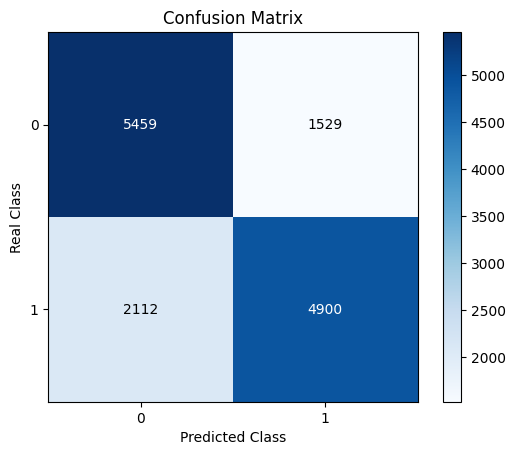

In [ ]:
# Use the complete_preparation function to prepare the data
X_train, y_train, X_test, y_test, _, _ = complete_preparation(train_without_impossible_dataset, test_dataset, deg=2)

# Create and train the RandomForestClassifier model
params = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}
rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with annotated numbers
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Add numbers inside the cells
for i in range(len(classes)):
    for j in range(len(classes)):
        if i == j:
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='white')
        else:
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')

plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

---

Now let's see if we can improve our performance using ensemble learning.

---

In [ ]:
# # Use the complete_preparation function to prepare the data
# deg = range(1,3)
# train_datasets = {
#     "train_original_dataset": train_original,
#     "train_without_impossible_dataset": train_without_impossible_dataset,
#     "train_without_extreme_dataset": train_without_extreme_dataset
# }

# # Initialization of base classifiers
# classifiers_adaboost = [LogisticRegression(),DecisionTreeClassifier(),GaussianNB()]
# classifiers_voting_hard = [
#     ('RandomForest', RandomForestClassifier()),
#     ('DecisionTree', DecisionTreeClassifier()),
#     ('LogisticRegression', LogisticRegression()),
#     ('KNeighbors', KNeighborsClassifier()),
#     ('GaussianNB', GaussianNB()),
#     ('SVC', SVC())
# ]
# classifiers_voting_soft = [
#     ('RandomForest', RandomForestClassifier()),
#     ('DecisionTree', DecisionTreeClassifier()),
#     ('LogisticRegression', LogisticRegression()),
#     ('KNeighbors', KNeighborsClassifier()),
#     ('GaussianNB', GaussianNB())
# ]

# # Initialization of classifiers
# adaboost_classifiers = [AdaBoostClassifier(base_classifier, n_estimators=50) for base_classifier in classifiers_adaboost]
# gradboost_classifiers = [GradientBoostingClassifier(n_estimators=n) for n in range(50,450,50)]
# voting_classifiers_hard = VotingClassifier(estimators=classifiers_voting_hard, voting='hard')
# voting_classifiers_soft = VotingClassifier(estimators=classifiers_voting_soft, voting='soft')

# # List of classifiers
# boosting = [adaboost_classifiers,gradboost_classifiers]
# voting = [voting_classifiers_hard,voting_classifiers_soft]

# # Ensemble Learning training
# for deg in range_of_degrees:
#   for train_dataset_name, train_dataset in train_datasets.items():
#     X_train, y_train, X_test, y_test, _, _ = complete_preparation(train_dataset, test_dataset, deg=deg)
#     # Boosting
#     for classifiers in boosting:
#       for model in classifiers:
#         print(f"---> Classifier name: {model} - Degree: {deg} - Training data: {train_dataset_name}")
#         # Now let's train on the entire training data with the best parameters
#         metrics_dict = training_and_performance_assessment(model, X_train, y_train, X_test, y_test)
#         # Now let's save the metrics in the results excel file
#         content_for_excel = [str(model), deg, train_dataset_name.split("_")[2]]
#         for _, metric_value in metrics_dict.items():
#             content_for_excel.append(round(metric_value, 3))
#         # Write the results in excel
#         write_to_excel(path_excel_ensemble_learning, content_for_excel)
#     # Voting
#     for model in voting:
#       print(f"---> Classifier name: {model} - Degree: {deg} - Training data: {train_dataset_name}")
#       # Now let's train on the entire training data with the best parameters
#       metrics_dict = training_and_performance_assessment(model, X_train, y_train, X_test, y_test)
#       # Now let's save the metrics in the results excel file
#       content_for_excel = [str(model), deg, train_dataset_name.split("_")[2]]
#       for _, metric_value in metrics_dict.items():
#           content_for_excel.append(round(metric_value, 3))
#       # Write the results in excel
#       write_to_excel(path_excel_ensemble_learning, content_for_excel)

---

All the results of this execution are in the results_ensemble_learning.xlsx file

---